In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

from tempfile import TemporaryFile
import os
import pickle
import random
import operator

import math

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]      # mean matrix
    cm1 = instance1[1]      # covariance
    mm2 = instance2[0]
    cm2 = instance2[1]

    distance = np.trace(np.matmul(np.linalg.inv(cm2), cm1))                     # returns the sum (along matrix diagonal) of the 2 multiplied arrays
    distance += np.matmul(np.matmul(mm2 - mm1, np.linalg.inv(cm2)), mm2 - mm1)
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))         # logs matrix determinants and subtracts them
    distance -= k
    
    return distance

In [3]:
# Find neighbors and distance between feature vectors

def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range(len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))
    distances.sort(key=operator.itemgetter(1))      # sorts the list on index 1 (distance) of elements (tuples) inside the list (callback)
    neighbors = [distances[x][0] for x in range(k)] # append first k neighbour labels
       
    return neighbors

In [4]:
# for x in range(k):
#     neighbors.append(distances[x][0])  

In [5]:
# Identifying the nearest neighbour

def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:       # gives votes for recurring genres
            classVote[response] += 1
        else:
            classVote[response] = 1
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)    # make a sorted list with first elem. being the highest one
    # print(len(sorter))
    if len(sorter) > 1 and sorter[0][1] == sorter[1][1]:
        return [sorter[0][0], sorter[1][0]]
    return [sorter[0][0]]     # prints the first element (one with the most votes)

In [6]:
    # classVote[8] = 2
    # classVote[10] = 2
    # max_vote = max(classVote.items(), key=operator.itemgetter(1))
    # return max_vote[0]

In [7]:
# Evaluates how accurate is the model
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return correct/len(testSet)

In [8]:
# writing directory constants
DIRECTORY = "../genres"
FOLDERS = next(os.walk(DIRECTORY), (None, [], None))[1]
DATASET_PATH = "../music_data/music_info.dat"

In [9]:
# extracting wav features to a .dat file

# f = open(DATASET_PATH, 'wb')
# i = 0

# for i in range(10):
#     folder = FOLDERS[i]
#     # print(folder)
#     i+=1
#     for file in os.listdir(DIRECTORY + folder):	
#         rate, data = wav.read(DIRECTORY + folder + "/" + file)
#         mfcc_feat = mfcc(data, rate, winlen=0.020, appendEnergy=False)
#         covariance = np.cov(np.matrix.transpose(mfcc_feat))
#         mean_matrix = mfcc_feat.mean(0)
#         feature = (mean_matrix, covariance, i)
#         pickle.dump(feature, f)

# f.close()

In [10]:
# Training and splitting sets for testing
dataset_testing = []
def loadTestingDataset(filename, split, trSet, teSet):
    with open(DATASET_PATH, 'rb') as f:
        while True:
            try:
                dataset_testing.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    
    for x in range(len(dataset_testing)):
        if random.random() < split:
            trSet.append(dataset_testing[x])
        else:
            teSet.append(dataset_testing[x])

trainingSet = []
testSet = []
loadTestingDataset(DATASET_PATH, 0.66, trainingSet, testSet)
print(testSet[1][-1])

1


In [11]:
# for x in testSet:
#     print(x[-1])

In [12]:
# Predicting with KNN

# leng = len(testSet)
# predictions = []
# for x in range (leng):
#     predictions.append(nearestClass(getNeighbors(trainingSet, testSet[x], 5))[0])   # gives back all the results for every test audio file
# print(predictions)
# accuracy1 = getAccuracy(testSet, predictions)       # compares actual genre values with predicted values to give back accuracy
# print(accuracy1)

In [13]:
## Testing

In [14]:
dataset = []
def loadDataset(filename):
    with open(DATASET_PATH, 'rb') as f:
        while True:
            try:
               dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break

loadDataset(DATASET_PATH)

In [15]:
rate, data = wav.read(f"../music_files/ryo-mono.wav")

mfcc_feat = mfcc(data, rate, winlen=0.020, appendEnergy=False)  # makes a MFCC
covariance = np.cov(np.matrix.transpose(mfcc_feat))             # transposes the list to (13, 2993) and then covariates it into (13, 13)
mean_matrix = mfcc_feat.mean(0)                                 # makes a (13,) mean (means the [0] elemnts which is 2993 rows)
feature = (mean_matrix, covariance, 0)

pred = nearestClass(getNeighbors(dataset, feature, 25))
pred = [x-1 for x in pred]

genre_res = FOLDERS[pred[0]]

if len(pred) > 1:
    genre_res += "/"+FOLDERS[pred[1]]
    
print(genre_res)

country


In [16]:
print(feature[1].shape, dataset[0][1].shape)

(13, 13) (13, 13)


In [17]:
print(mean_matrix)
print("--------------------------------")
print(np.matrix.transpose(mfcc_feat).shape)     # what we see in spectogram
print("--------------------------------")
print(covariance.shape)

print(mfcc_feat.shape)                          # how data comes originally

[62.84657312 13.03384288  1.03091434 -3.15537873 -2.13933547 -2.4441309
 -6.31432007  0.09053576 -0.62832836 -1.82207724 -3.67170606 -4.02731374
 -4.82124907]
--------------------------------
(13, 2993)
--------------------------------
(13, 13)
(2993, 13)


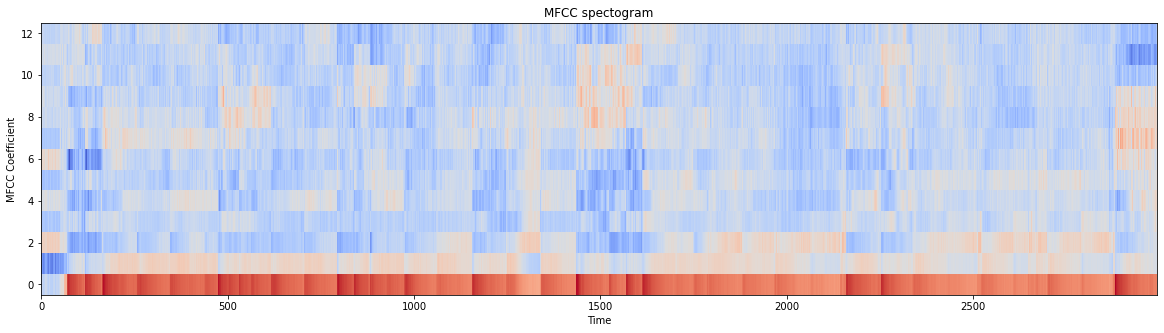

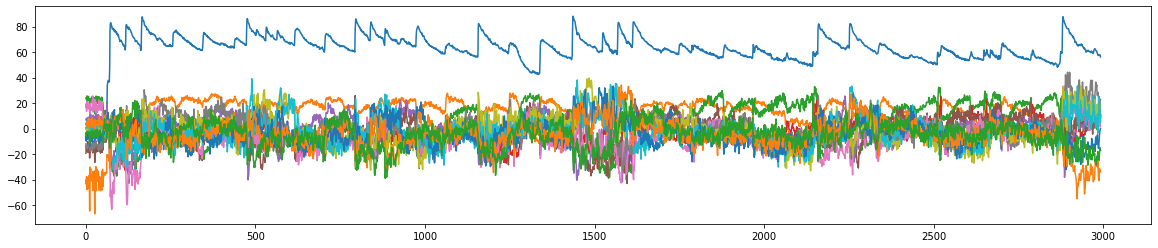

In [18]:
iq, ax = plt.subplots(figsize=(20, 5))
mfcc_data = np.swapaxes(mfcc_feat, 0, 1)
# mfcc_datu = np.matrix.transpose(mfcc_feat)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC spectogram')
ax.set_xlabel("Time")
ax.set_ylabel("MFCC Coefficient")
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(mfcc_feat)
plt.show()

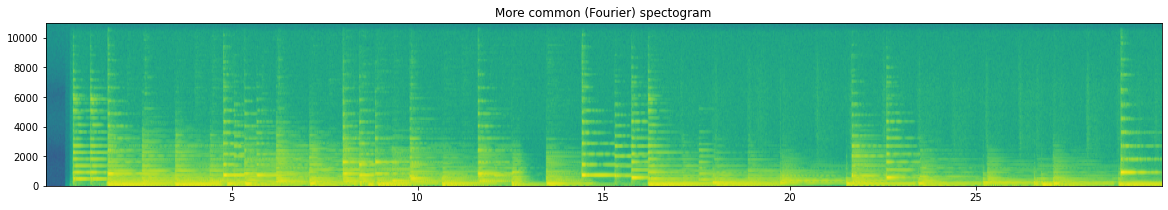

In [19]:
plt.figure(num=None, figsize=(20, 3))
plt.subplot(111)
plt.title('More common (Fourier) spectogram')
plt.specgram(data, Fs=rate)
plt.show()

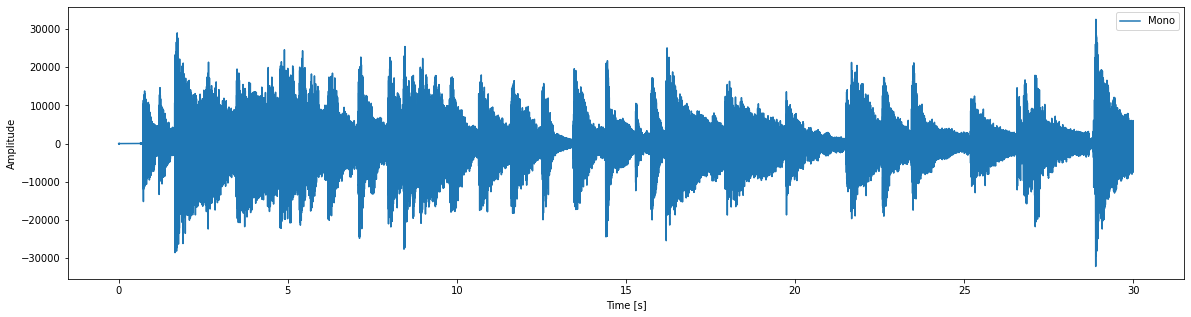

In [20]:
length = data.shape[0] / rate
time = np.linspace(0., length, data.shape[0])
plt.figure(figsize=(20, 5))
if len(data.shape) < 2:
    plt.plot(time, data, label="Mono")
else:
    plt.plot(time, data[:, 0], label="Left channel")
    plt.plot(time, data[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [21]:
print(data.shape)

(661500,)


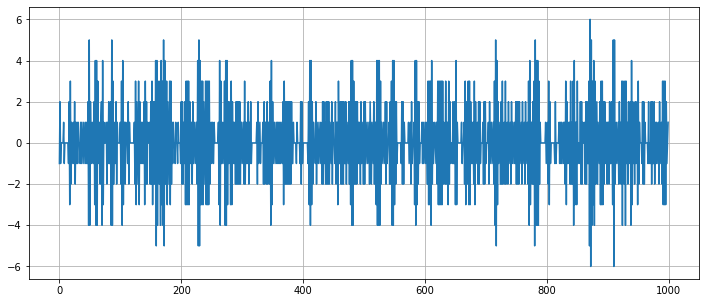

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(data[0:1000]) # Zoom-in for seeing the example.
plt.grid()

In [23]:
print(FOLDERS)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
